In [1]:
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt

# The envelope detector implemented using the Hilbert transform
# See: https://blog.csdn.net/m0_37262671/article/details/125303404
def get_envelope(x, n=None):
    analytic_signal = hilbert(x, N=n)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

def butter_lowpass(cutoff_frequency, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff_frequency, fs, order=4):
    b, a = butter_lowpass(cutoff_frequency, fs, order=order)
    y = lfilter(b, a, data)
    return y  

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y   

# produce AWGN noise
def awgn(x, snr_dB): # SNR in dB
    snr = 10**(snr_dB/10.0)
    xpower = np.sum(x**2)/len(x)    # power of input signal
    npower = xpower / snr        # power of noise calculated by SNR
    # gaussian noise
    noise = np.random.randn(len(x)) * np.sqrt(npower)
    return noise, npower

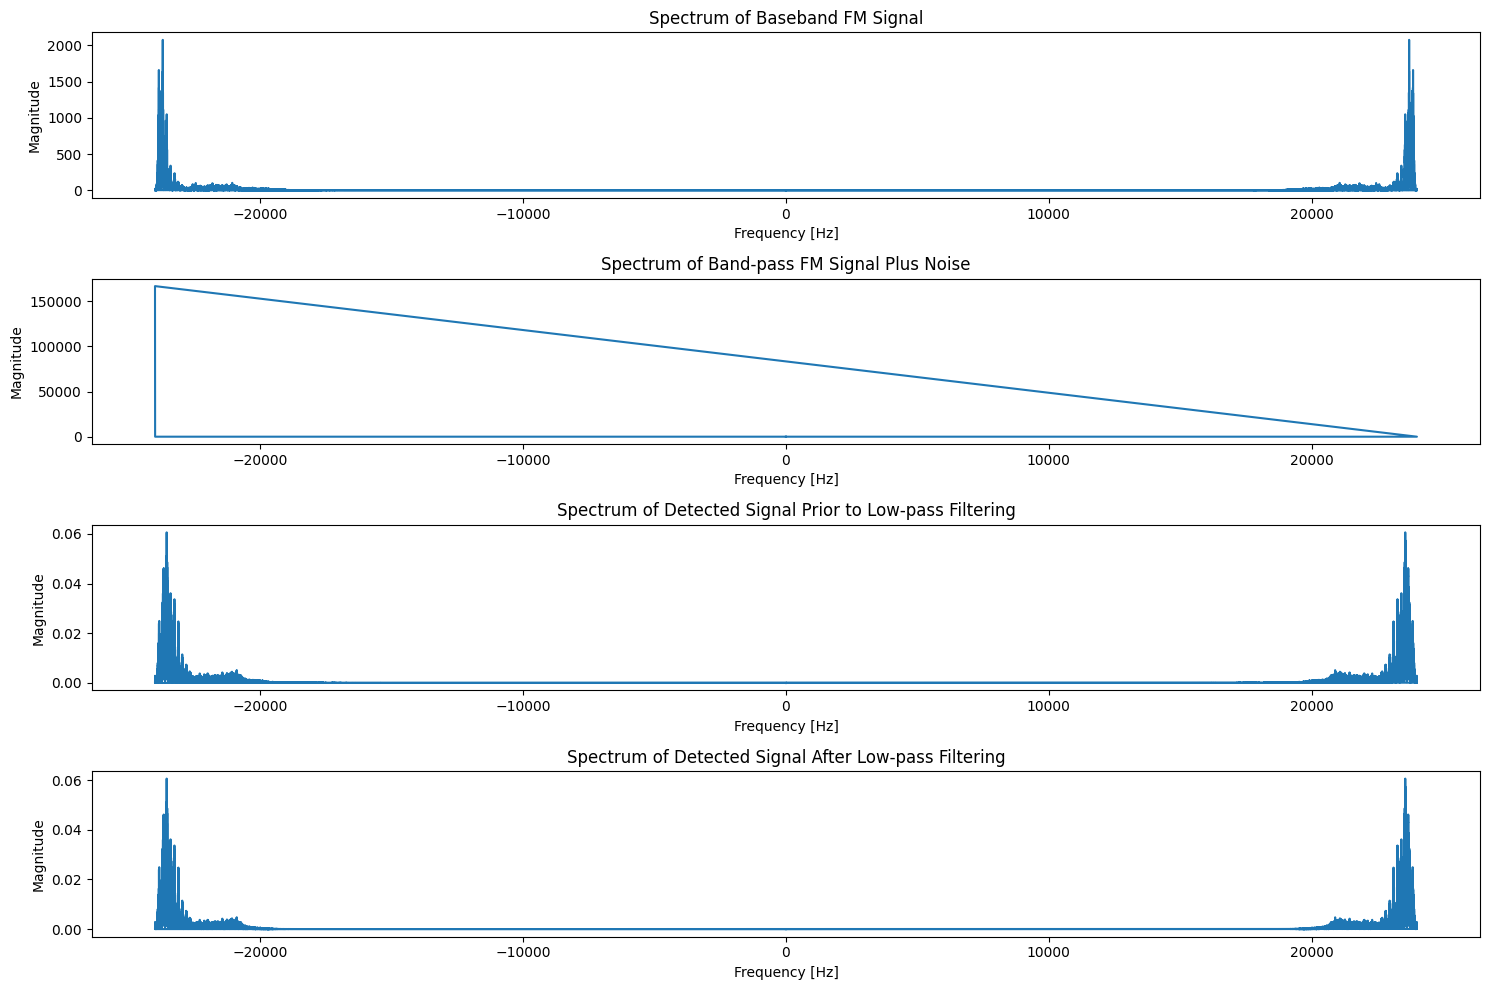

(array([1.        , 1.        , 1.        , ..., 0.99999999, 0.99999999,
        0.99999999]),
 array([0.97187194, 0.97187194, 0.97187194, ..., 0.97187194, 0.97187194,
        0.97187194]),
 array([ 0.00000000e+00,  3.24492351e-05,  8.36144178e-09, ...,
        -1.08052770e-05,  8.36186116e-09, -3.24325232e-05]),
 array([-9.25849657e-09,  2.28357028e-06,  4.21493094e-06, ...,
        -1.45320053e-05, -2.30215583e-05, -3.23739690e-05]))

In [9]:
from scipy.signal import butter, lfilter, freqz, hilbert
# generate message from wav
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile
from scipy import signal

kf = 0.3
fc = 1e4
bw = 4e3

fs, orig_data = wavfile.read('audio.wav')
message = butter_lowpass_filter(orig_data / np.max(np.abs(orig_data)), bw, fs, order=8)
t = np.arange(0, 1, len(message))  # Time vector

# calculate frequency deviation
deviation = kf*max(message)

# 2. Perform Frequency Modulation (FM)
integral_of_message = np.cumsum(message) / fs
fm_signal = np.cos(2 * np.pi * fc * t + 2 * np.pi * deviation * integral_of_message)

# 3. Add AWGN Noise
noise_power = 0.01  # Noise power
noise = np.sqrt(noise_power) * np.random.normal(size=len(t))
fm_noisy_signal = fm_signal + noise

# 4. Frequency Demodulation
# For simplicity, using the derivative of the phase of the analytical signal
analytic_signal = hilbert(fm_noisy_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) * (fs / (2.0 * np.pi))
demodulated_signal = np.insert(instantaneous_frequency, 0, 0)  # Add a value for t=0

# Low-pass filter for demodulated signal (for post-detection)
b, a = butter(5, 2 * bw / fs, 'low')  # Low-pass filter with a cutoff at 50 Hz
filtered_demodulated_signal = filtfilt(b, a, demodulated_signal)

# 5. Plots
plt.figure(figsize=(15, 10))

# generate f for baseband_fm_spectrum
f = np.fft.fftfreq(len(message), 1/fs)

# Spectrum of the baseband FM signal
plt.subplot(4, 1, 1)
baseband_fm_spectrum = fftshift(fft(message))
plt.plot(f, np.abs(baseband_fm_spectrum))
plt.title('Spectrum of Baseband FM Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Spectrum of the band-pass FM signal plus noise
plt.subplot(4, 1, 2)
bandpass_fm_spectrum = fftshift(fft(fm_noisy_signal))
plt.plot(f, np.abs(bandpass_fm_spectrum))
plt.title('Spectrum of Band-pass FM Signal Plus Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Spectrum of the detected signal prior to low-pass filtering
plt.subplot(4, 1, 3)
detected_spectrum_pre_filter = fftshift(fft(demodulated_signal))
plt.plot(f, np.abs(detected_spectrum_pre_filter))
plt.title('Spectrum of Detected Signal Prior to Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Spectrum of the detected signal after low-pass filtering
plt.subplot(4, 1, 4)
detected_spectrum_post_filter = fftshift(fft(filtered_demodulated_signal))
plt.plot(f, np.abs(detected_spectrum_post_filter))
plt.title('Spectrum of Detected Signal After Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

# SNR comparison will be performed next.
fm_signal, fm_noisy_signal, demodulated_signal, filtered_demodulated_signal

In [7]:
# Calculate SNR for FM signals
def snr_fm(signal, noise, fs):
    """ Calculate Signal-to-Noise Ratio (SNR) for FM signals """
    signal_power = np.var(signal)
    noise_power = np.var(noise)
    return 10 * np.log10(signal_power / noise_power)

# Pre-detection SNR for FM
pre_detection_snr_fm = snr_fm(fm_signal, noise, fs)

# Post-detection SNR for FM (after low-pass filtering)
post_detection_snr_fm = snr_fm(filtered_demodulated_signal, noise, fs)

pre_detection_snr_fm, post_detection_snr_fm

C:\Users\zhong\AppData\Local\Temp\ipykernel_18036\2245549312.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10(signal_power / noise_power)


(inf, inf)